In [175]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

we will use FashionMNIST data

In [176]:
# setting up training data
train_data = datasets.FashionMNIST(root="data", # where to download data to
                                   train=True, # get training data
                                   download=True, # download data if it does not exist on disk
                                   transform=ToTensor(), # images come in PIL format, we want to turn it into tensor
                                   target_transform=None # we can transform labels as well
                                   )

# setting up testing data
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor())

In [177]:
# looking at first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [178]:
# shape of the image
image.shape

torch.Size([1, 28, 28])

In [179]:
# how many samples are there
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

we can see we have 60000 training examples and 10000 testing examples

In [180]:
# see classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

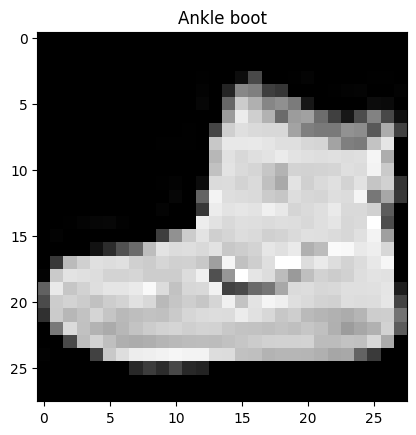

In [181]:
# visualizing the dat
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.show()

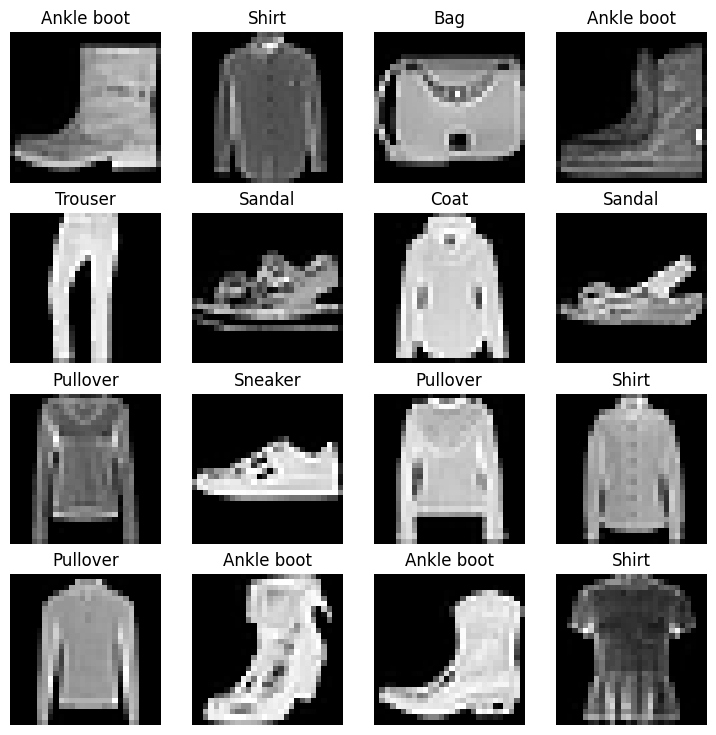

In [182]:
# plotting more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [183]:
# data loader

from torch.utils.data import DataLoader

BATCH_SIZE=32

# turn dataset into batches using data loader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True) # shuffle data for training

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False) # no need to shuffle test data

In [184]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

* for training data, we have 1875 batches of 32
* for testing data, we have 313 batches of 32

In [185]:
# checking out what is inside training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 1. Building a Baseline model

In [186]:
# create a flatten layer
flatten_model = nn.Flatten()

# get a single sample from the batch
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)

print(f"shape before flattening: {x.shape}")
print(f"shape after flattening: {output.shape}")

shape before flattening: torch.Size([1, 28, 28])
shape after flattening: torch.Size([1, 784])


In [187]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        x = self.layer_stack(x)
        return x

In [188]:
torch.manual_seed(42)

# need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, 
                              output_shape=len(class_names))

In [189]:
# setting up loss function, optimizer and evaluation metrics
from torch import optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(), lr=0.1)

# function to calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [190]:
for batch, (X,y) in enumerate(train_dataloader):
    print(batch) # thus will just print the batch sequence, every batch will contain X and y as trianing feature and training label

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [191]:
# importing tqdm for progress bar
from tqdm.auto import tqdm
import time

# setting seed and starting timer
torch.manual_seed(42)
epochs=5

start = time.time()

for epoch in tqdm(range(epochs)):

    print(f"Epoch {epoch}\n-------------------------------")

    # ----------- training loop -------------

    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X) # forward pass
        loss = loss_fn(y_pred, y) # calculating loss
        train_loss += loss # accumalitively add up the loss per epoch
        optimizer.zero_grad() # zeroing the gradient
        loss.backward() # backpropogating the loss
        optimizer.step() # stepping the optimizer

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss = (train_loss/len(train_dataloader)) # average training loss per epoch

    # ----------- testing loop --------------
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

end = time.time()

total_time_model_0 = end - start

print(f"Total time taken: {total_time/60:.2f} minutes")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:01<00:07,  1.91s/it]

Epoch: 0, Train Loss: 0.5904, Test Loss: 0.5095, Test Accuracy: 82.0387
Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:03<00:05,  1.89s/it]

Epoch: 1, Train Loss: 0.4763, Test Loss: 0.4799, Test Accuracy: 83.1969
Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:05<00:03,  1.90s/it]

Epoch: 2, Train Loss: 0.4550, Test Loss: 0.4766, Test Accuracy: 83.4265
Epoch 3
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:07<00:01,  1.89s/it]

Epoch: 3, Train Loss: 0.4425, Test Loss: 0.4631, Test Accuracy: 83.7460
Epoch 4
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]

Epoch: 4, Train Loss: 0.4358, Test Loss: 0.4687, Test Accuracy: 83.2668
Total time taken: 3.52 minutes


In [192]:
# Writting generic function for model results evaluation

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": acc
    }

In [193]:
# calculating model_0 results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4686938524246216,
 'model_accuracy': 83.2667731629393}

# 2. Building a better model with non-linearity

In [194]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [195]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
)

In [196]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [197]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn
              ):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:

            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [198]:
epochs = 5
start = time.time()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )
end = time.time()

total_time_model_1 = end - start
print(f"Total time taken: {total_time/60:.2f} minutes")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.05878 | Train accuracy: 62.19%


 20%|██        | 1/5 [00:01<00:07,  1.93s/it]

Test loss: 0.99506 | Test accuracy: 64.13%

Epoch: 1
---------
Train loss: 0.91331 | Train accuracy: 66.40%


 40%|████      | 2/5 [00:03<00:05,  1.92s/it]

Test loss: 0.90508 | Test accuracy: 66.86%

Epoch: 2
---------
Train loss: 0.87981 | Train accuracy: 67.25%


 60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

Test loss: 0.89485 | Test accuracy: 66.47%

Epoch: 3
---------
Train loss: 0.86324 | Train accuracy: 67.61%


 80%|████████  | 4/5 [00:07<00:01,  1.92s/it]

Test loss: 0.90665 | Test accuracy: 66.48%

Epoch: 4
---------
Train loss: 0.84879 | Train accuracy: 68.14%


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]

Test loss: 0.86984 | Test accuracy: 67.26%

Total time taken: 3.52 minutes


In [199]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code 
model_1_results = eval_model(model=model_1, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn) 
model_1_results 

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.8698430061340332,
 'model_accuracy': 67.2623801916933}

# 3. Building a Convolutional Neural Network

In [200]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # default value of stride is "kernel_size"
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [201]:
torch.manual_seed(42)

# Create model
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=32, output_shape=len(class_names))


* input_shape=1 means there is one channel in the image, and hidden_units=32 means there will be 32 feature maps 

* if the number of feature maps produced are more than 32, only 32 will be selected for further computation and rest will be ignored.

In [202]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [203]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 

epochs = 3

start = time.time()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

end = time.time()

total_time_model_2 = end - start
print(f"Total time taken: {total_time/60:.2f} minutes")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.51076 | Train accuracy: 81.39%


 33%|███▎      | 1/3 [01:09<02:19, 69.83s/it]

Test loss: 0.34689 | Test accuracy: 87.58%

Epoch: 1
---------
Train loss: 0.30882 | Train accuracy: 88.85%


 67%|██████▋   | 2/3 [02:19<01:09, 69.89s/it]

Test loss: 0.29779 | Test accuracy: 89.10%

Epoch: 2
---------
Train loss: 0.26814 | Train accuracy: 90.35%


100%|██████████| 3/3 [03:31<00:00, 70.50s/it]

Test loss: 0.27259 | Test accuracy: 90.36%

Total time taken: 3.52 minutes


In [204]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2725897431373596,
 'model_accuracy': 90.35543130990415}

# Comparing model results and training time

In [205]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_accuracy
0,FashionMNISTModelV0,0.468694,83.266773
1,FashionMNISTModelV1,0.869843,67.262380
2,FashionMNISTModelV2,0.272590,90.355431


In [206]:
# Add training times to results comparison
compare_results["training_time"] = [total_time_model_0,
                                    total_time_model_1,
                                    total_time_model_2]
compare_results

,model_name,model_loss,model_accuracy,training_time
0,FashionMNISTModelV0,0.468694,83.266773,9.471271
1,FashionMNISTModelV1,0.869843,67.262380,9.599909
2,FashionMNISTModelV2,0.272590,90.355431,211.493755


Text(0, 0.5, 'model')

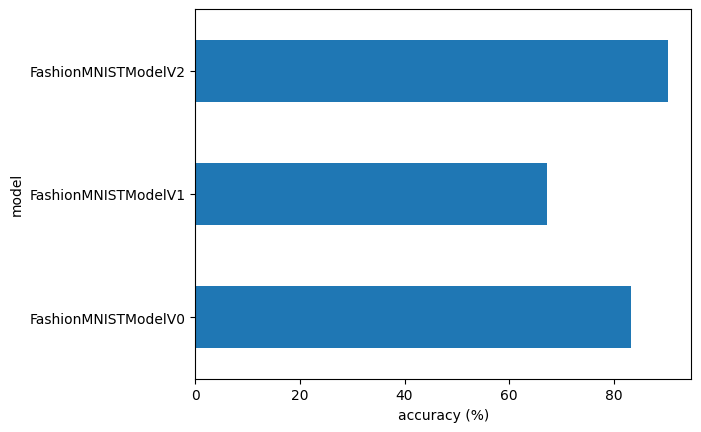

In [208]:
# Visualize our model results
compare_results.set_index("model_name")["model_accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

# Evaluating random predictions with best model

In [229]:
def make_predictions(model: torch.nn.Module, 
                     data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0) # adding batch dimension
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # don't perform softmax on batch dimension
            pred_probs.append(pred_prob)
    # stacking pred_probs to turn list into tensor
    return torch.stack(pred_probs)


In [226]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [227]:
test_samples[0].shape

torch.Size([1, 28, 28])

In [231]:
# making predictions on random test samples with model_2

pred_probs = make_predictions(model=model_2, data=test_samples)

# viewing first two prediction probabilities list
pred_probs[:2]

tensor([[9.5016e-08, 2.0955e-09, 1.1678e-08, 1.1466e-09, 1.9191e-09, 9.9999e-01,
         4.3930e-07, 4.7167e-08, 1.7234e-06, 1.0941e-05],
        [1.7836e-02, 9.3897e-01, 5.7142e-04, 2.0153e-02, 1.5887e-02, 2.0418e-04,
         5.8668e-03, 1.2702e-04, 2.0972e-04, 1.7259e-04]])

In [232]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [233]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

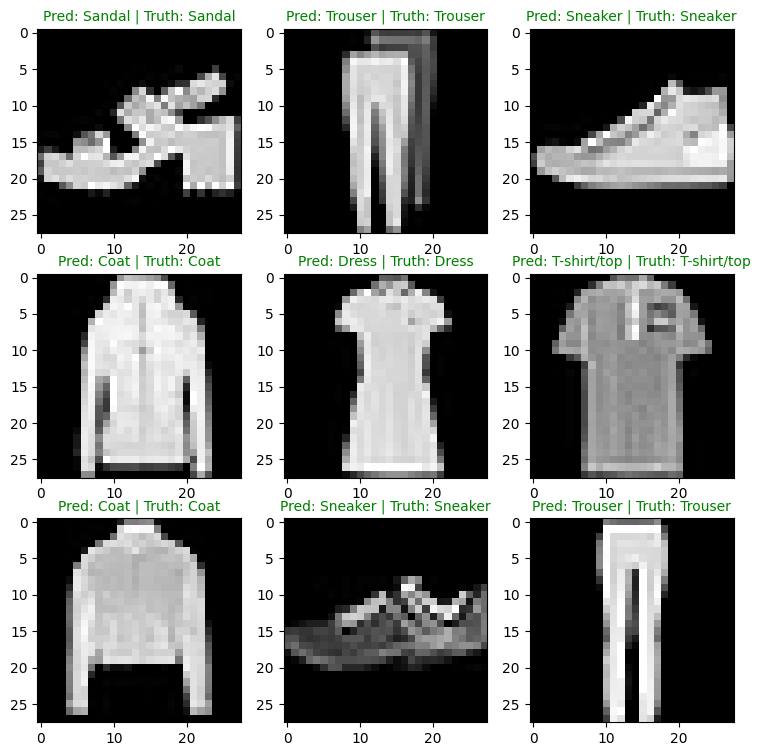

In [234]:
# visualizing the results
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # creating a subplot
    plt.subplot(nrows, ncols, i+1)
    # plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # prediction label
    pred_label = class_names[pred_classes[i]]
    # truth label
    truth_label = class_names[test_labels[i]]
    # title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    # Checking for equality and changing title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
        plt.axis(False)

# Confusion matrix for further performance evaluation

In [235]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="making predictions"):
        y_logit = model_2(X)
        # logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)


print(type(y_preds))
# concatenate list of predictions into tensor
# note - here we will have list of tensors (of size 32 each )which we will concatenate
y_pred_tensor = torch.cat(y_preds)
print(type(y_pred_tensor))

making predictions: 100%|██████████| 313/313 [00:02<00:00, 110.36it/s]

<class 'list'>
<class 'torch.Tensor'>


In [242]:
y_preds[0].shape

torch.Size([32])

In [238]:
y_pred_tensor.shape

torch.Size([10000])

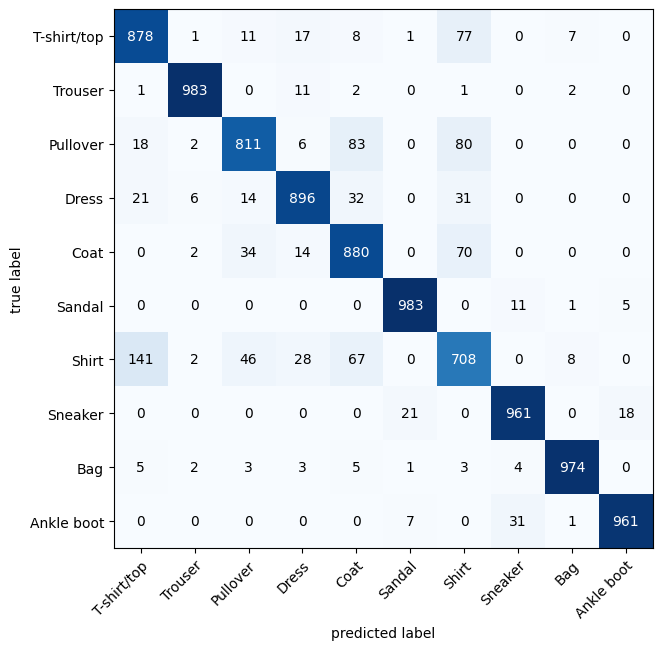

In [243]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setting up confusion mastrfic indtacce
confusion_matrix = ConfusionMatrix(num_classes=len(class_names),
                                   task="multiclass")
confusion_matrix_tensor = confusion_matrix(preds=y_pred_tensor, target=test_data.targets)


# create confusion matrci
fix, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

# Saving and Loading best performing model

In [244]:
from pathlib import Path

# creating models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories
                exist_ok=True # if models directory already exists, don't give out error
                )

# create model and save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(), # only saving the learned parameters i.e weights and biases
            f=MODEL_SAVE_PATH
            )

In [245]:
# loading saved model

"""
for loading a model, we need to create a new instance of the same model 
class with the same input parameters as our saved model
"""
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=32, output_shape=len(class_names))

# load the saved model parameters
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [246]:
# now we can evaluate the loaded model
loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2725897431373596,
 'model_accuracy': 90.35543130990415}

In [247]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2725897431373596,
 'model_accuracy': 90.35543130990415}

In [248]:
# checking to see if the results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001 # relative tolerance
              )

tensor(True)